In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-dataset/hindi_preprocessed_2.csv
/kaggle/input/mbert-english/transformers/2/1/config.json
/kaggle/input/mbert-english/transformers/2/1/tokenizer_config.json
/kaggle/input/mbert-english/transformers/2/1/model.safetensors
/kaggle/input/mbert-english/transformers/2/1/special_tokens_map.json
/kaggle/input/mbert-english/transformers/2/1/vocab.txt


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

2024-05-02 07:17:47.389339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 07:17:47.389438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 07:17:47.562985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df =  pd.read_csv("/kaggle/input/hindi-dataset/hindi_preprocessed_2.csv")

df.rename(columns = {'text':'sentence', 'task_1':'label'}, inplace = True)

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(10)

Number of training sentences: 4,594



,sentence,label
2796,हमारे कब्र में पाँव लटके हुऐ है,1
3440,सब बात छोड़िये इसे ट्रेंड करवाइये,1
2167,सिवान के शेर डॉक्टर शहाबुद्दीन साहब की मौतकत्ल...,1
1279,हिंदू मुस्लिम एकता अब नही देख लिया इन सुअरो को,0
2109,गैंग ऑफ वासेपुर की याद आ रही है मरहूम शहाबुद्द...,0
475,कहाँ गए अभी अवार्ड वापसी गैंगबंगाल में तुमलोगो...,1
2916,महाभारत से भी बड़ा युद्ध तुम्हारा इंतजार कर रह...,1
3444,ओबीसी नहीं सब जाती का अलग गिनती हो ताकि सभी जा...,1
101,थोड़ा और कोशिश करे,1
4194,जितिन प्रसाद की जरूरत ही नहीं ऐसे चुटिया लोग क...,0


# Loading finetuned mbert model (on english dataset)

In [5]:
from transformers import AutoModelForSequenceClassification, BertTokenizer
import tensorflow as tf
# Specify the directory where the model and tokenizer are saved
saved_model_dir = '/kaggle/input/mbert-english/transformers/2/1'

# Load the model and tokenizer
tokenizer = BertTokenizer.from_pretrained(saved_model_dir)
model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir)

In [6]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [7]:
sentences = df.sentence.values
labels = df.label.values

# Create lists to store valid sentences and corresponding labels
cleaned_sentences = []
cleaned_labels = []

# Remove NaN sentences and corresponding labels
for sent, label in zip(sentences, labels):
    if isinstance(sent, str):
        cleaned_sentences.append(sent)
        cleaned_labels.append(label)
sentences = cleaned_sentences
labels = cleaned_labels

In [8]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  322


**Tokenizing all of the sentences and mapping the tokens to thier word IDs.**

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
   
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Evaluating on hindi text

In [10]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []


# Predict
count =0
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction   
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        count+=len(b_input_ids)
        result = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         return_dict=True)


        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

print(f"count = {count}")
print('    DONE.')


Predicting labels for 4,594 test sentences...
count = 4594
    DONE.


# F1 Score

In [11]:
from sklearn.metrics import f1_score

# Combine the predictions from all batches
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(all_predictions, axis=1)

# Compute F1 score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1 Score:", f1)

F1 Score: 0.5121261409304068


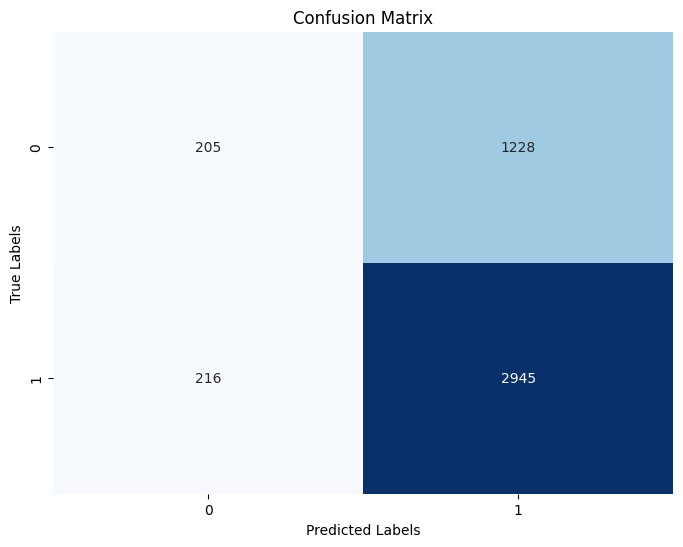

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(all_true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.49      0.14      0.22      1433
     class 1       0.71      0.93      0.80      3161

    accuracy                           0.69      4594
   macro avg       0.60      0.54      0.51      4594
weighted avg       0.64      0.69      0.62      4594

